In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pysensors as ps

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True)
X = faces.data

n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)

# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

Number of samples: 400
Number of features (sensors): 4096


In [3]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    '''Function for plotting faces'''
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

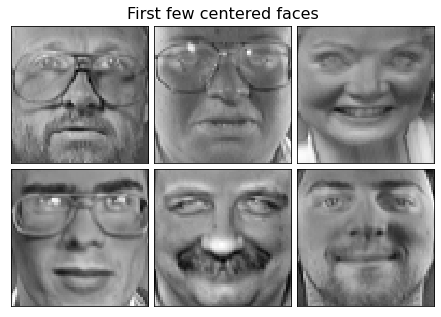

In [4]:
plot_gallery("First few centered faces", X[:n_components])

In [5]:
# reduce the X
imageSize = 64
image_shape = (imageSize, imageSize)

X = X[:,:imageSize**2]
n_features = X.shape[1]

#Find all sensor locations using built in QR optimizer
max_const_sensors = 230
n_const_sensors = 0
n_sensors = 399
optimizer  = ps.optimizers.QR()
model = ps.SSPOR(optimizer=optimizer, n_sensors=n_sensors)
model.fit(X)

all_sensors = model.get_all_sensors()
print(all_sensors)

[4032  384 4092 ... 1912 3987 2369]


In [6]:
#Define Constrained indices
a = np.unravel_index(all_sensors, (imageSize,imageSize))
print(a)
a_array = np.transpose(a)
print(a_array.shape)
#idx = np.ravel_multi_index(a, (64,64))
#print(idx)
xmin = 0
xmax = 10
ymin = 40
ymax = 64

constrained_sensorsx = []
constrained_sensorsy = []
for i in range(n_features):
    if a[0][i] < xmax and a[1][i] > ymin:  # x<10 and y>40
        constrained_sensorsx.append(a[0][i])
        constrained_sensorsy.append(a[1][i])

constrained_sensorsx = np.array(constrained_sensorsx)
constrained_sensorsy = np.array(constrained_sensorsy)

constrained_sensors_array = np.stack((constrained_sensorsy, constrained_sensorsx), axis=1)
constrained_sensors_tuple = np.transpose(constrained_sensors_array)


#print(constrained_sensors_tuple)
#print(len(constrained_sensors_tuple))
idx_constrained = np.ravel_multi_index(constrained_sensors_tuple, (imageSize,imageSize))

#print(len(idx_constrained))
#print(constrained_sensorsx)
#print(constrained_sensorsy)
#print(idx_constrained)
print(np.sort(idx_constrained[:]))
all_sorted = np.sort(all_sensors)
#print(all_sorted)
idx = np.arange(all_sorted.shape[0])
#all_sorted[idx_constrained] = 0

(array([63,  6, 63, ..., 29, 62, 37]), array([ 0,  0, 60, ..., 56, 19,  1]))
(4096, 2)
[2624 2625 2626 2627 2628 2629 2630 2631 2632 2633 2688 2689 2690 2691
 2692 2693 2694 2695 2696 2697 2752 2753 2754 2755 2756 2757 2758 2759
 2760 2761 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2880 2881
 2882 2883 2884 2885 2886 2887 2888 2889 2944 2945 2946 2947 2948 2949
 2950 2951 2952 2953 3008 3009 3010 3011 3012 3013 3014 3015 3016 3017
 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3264 3265 3266 3267 3268 3269 3270 3271 3272 3273 3328 3329
 3330 3331 3332 3333 3334 3335 3336 3337 3392 3393 3394 3395 3396 3397
 3398 3399 3400 3401 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465
 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3584 3585 3586 3587
 3588 3589 3590 3591 3592 3593 3648 3649 3650 3651 3652 3653 3654 3655
 3656 3657 3712 3713 3714 3715 3716 3717 3718 3719 3720 3721 

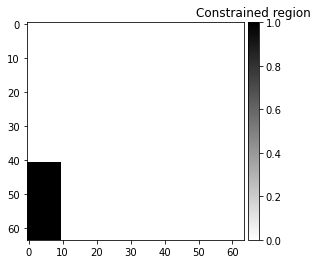

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot()
#Plot constrained space
img = np.zeros(n_features)
img[idx_constrained] = 1
im = plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.title('Constrained region');

In [8]:
#New class for constrained sensor placement
from pysensors.optimizers._qr import QR
class GQR(QR):
    """
    General QR optimizer for sensor selection.
    Ranks sensors in descending order of "importance" based on
    reconstruction performance. 

    See the following reference for more information

        Manohar, Krithika, et al.
        "Data-driven sparse sensor placement for reconstruction:
        Demonstrating the benefits of exploiting known patterns."
        IEEE Control Systems Magazine 38.3 (2018): 63-86.
    """
    def __init__(self):
        """
        Attributes
        ----------
        pivots_ : np.ndarray, shape [n_features]
            Ranked list of sensor locations.
        """
        self.pivots_ = None
    
    def fit(
        self,
        basis_matrix, idx_constrained, const_sensors
    ):
        """
        Parameters
        ----------
        basis_matrix: np.ndarray, shape [n_features, n_samples]
            Matrix whose columns are the basis vectors in which to
            represent the measurement data.
        optimizer_kws: dictionary, optional
            Keyword arguments to be passed to the qr method.

        Returns
        -------
        self: a fitted :class:`pysensors.optimizers.CCQR` instance
        """

        n, m = basis_matrix.shape  # We transpose basis_matrix below

        ## Assertions and checks:
        if n_sensors > n_features - max_const_sensors + n_const_sensors: ##TODO should be moved to the class
            raise IOError ("n_sensors cannot be larger than n_features - all possible locations in the constrained area + allowed constrained sensors")
        if n_sensors > n_samples + n_const_sensors:
            raise IOError ("Currently n_sensors should be less than number of samples + number of constrained sensors,\
                           got: n_sensors = {}, n_samples + n_const_sensors = {} + {} = {}".format(n_sensors,n_samples,n_const_sensors,n_samples+n_const_sensors))    
            
        # Initialize helper variables
        R = basis_matrix.conj().T.copy()
        #print(R.shape)
        p = np.arange(n)
        #print(p)
        k = min(m, n)
        
      
        for j in range(k):
            r = R[j:, j:]
            # Norm of each column
            dlens = np.sqrt(np.sum(np.abs(r) ** 2, axis=0))
            
            dlens_updated = f_region(idx_constrained,dlens,p,j, const_sensors)
            
            # Choose pivot
            i_piv = np.argmax(dlens_updated)
            #print(i_piv)
            
            
            dlen = dlens_updated[i_piv]
            
            if dlen > 0:
                u = r[:, i_piv] / dlen
                u[0] += np.sign(u[0]) + (u[0] == 0)
                u /= np.sqrt(abs(u[0]))
            else:
                u = r[:, i_piv]
                u[0] = np.sqrt(2)
                
            # Track column pivots
            i_piv += j # true permutation index is i_piv shifted by the iteration counter j
            print(i_piv) # Niharika's debugging line
            p[[j, i_piv]] = p[[i_piv, j]]
            print(p)


            # Switch columns
            R[:, [j, i_piv]] = R[:, [i_piv, j]]
            
            # Apply reflector
            R[j:, j:] -= np.outer(u, np.dot(u, R[j:, j:]))
            R[j + 1 :, j] = 0
            

        self.pivots_ = p
    

        return self
#function for mapping sensor locations with constraints
def f_region(lin_idx, dlens, piv, j, const_sensors): 
    #num_sensors should be fixed for each custom constraint (for now)
    #num_sensors must be <= size of constraint region
    """
    Function for mapping constrained sensor locations with the QR procedure.
    
    Parameters
        ----------
        lin_idx: np.ndarray, shape [No. of constrained locations]
            Array which contains the constrained locations mapped on the grid.
        dlens: np.ndarray, shape [Variable based on j]
            Array which contains the norm of columns of basis matrix.
         num_sensors: int, 
            Number of sensors to be placed in the constrained area.
        j: int,
            Iterative variable in the QR algorithm.

        Returns
        -------
        dlens : np.darray, shape [Variable based on j] with constraints mapped into it. 
    """
    if j < const_sensors: # force sensors into constraint region
        #idx = np.arange(dlens.shape[0])        
        #dlens[np.delete(idx, lin_idx)] = 0
        
        didx = np.isin(piv[j:],lin_idx,invert=True)
        dlens[didx] = 0
    else: 
        didx = np.isin(piv[j:],lin_idx,invert=False)
        dlens[didx] = 0
    return dlens



In [9]:

optimizer1 = GQR()
model1 = ps.SSPOR(optimizer = optimizer1, n_sensors = n_sensors)
model1.fit(X, quiet=True, prefit_basis=False, seed=None, idx_constrained = idx_constrained, const_sensors = n_const_sensors)

4092
[4092    1    2 ... 4093 4094 4095]
320
[4092  320    2 ... 4093 4094 4095]
447
[4092  320  447 ... 4093 4094 4095]
493
[4092  320  447 ... 4093 4094 4095]
4042
[4092  320  447 ... 4093 4094 4095]
2204
[4092  320  447 ... 4093 4094 4095]
657
[4092  320  447 ... 4093 4094 4095]
878
[4092  320  447 ... 4093 4094 4095]
1088
[4092  320  447 ... 4093 4094 4095]
2560
[4092  320  447 ... 4093 4094 4095]
4087
[4092  320  447 ... 4093 4094 4095]
2837
[4092  320  447 ... 4093 4094 4095]
2395
[4092  320  447 ... 4093 4094 4095]
3098
[4092  320  447 ... 4093 4094 4095]
1023
[4092  320  447 ... 4093 4094 4095]
2011
[4092  320  447 ... 4093 4094 4095]
1224
[4092  320  447 ... 4093 4094 4095]
4042
[4092  320  447 ... 4093 4094 4095]
2966
[4092  320  447 ... 4093 4094 4095]
2783
[4092  320  447 ... 4093 4094 4095]
4095
[4092  320  447 ... 4093 4094   20]
1212
[4092  320  447 ... 4093 4094   20]
1115
[4092  320  447 ... 4093 4094   20]
1188
[4092  320  447 ... 4093 4094   20]
2815
[4092  320  447 

SSPOR(basis=Identity(n_basis_modes=400), n_sensors=399, optimizer=GQR())

In [10]:
all_sensors1 = model1.get_all_sensors()
print(all_sensors1[:n_const_sensors])

print(np.array_equal(np.sort(all_sensors),np.sort(all_sensors1)))

[]
True


[4092  320  447  493 4042 2204  657  878 1088 2560 4087 2837 2395 3098
 1023 2011 1224    4 2966 2783 4095 1212 1115 1188 2815 3352 3231 2975
 1140 3092 2339  969 4049 3643 2239 3614   59 1728 1101 4089 2586 1155
  691 1099 2201 2087 1535 3828 2898 2048  925  768 1138 3327  898 2733
 2845 1210 1113  994 4066 2207 2463  584 2986 2213 1068  790 1473 3220
 1894 1244 1109 2327 1278 2656 1094 3179 3107 3323  974 2014 2471  762
 3291   63  859 2007 3806 4091 4084  701 2154 2713 2493 1126 1603 1071
 4045 2333 3581 4079  597 2705 2304  749 2917 3364 1055 2431 1217 2793
  944  718 2280  340 3599    2 3041 1446 1102 3704 2260 1207 1344 1043
 3087 3160 2862 2562 2083 1919 3380  439 3583    0  960 1250  767 1021
  513 3071 1221 1899 2525 1041 1819 2467  836  581 1077  796 2135 2267
 3836 2907 3306 1961 2517  868 3321 3898 1794 3594 1240  948 1036 3421
 1661 3048 3958  817 2342 3886 1010 1242 3054 1097 1025  711 1854 1279
 4093 1600 3774  630  857 2021 1531 3026 2264 2141   57 2970 1090 1081
  787 

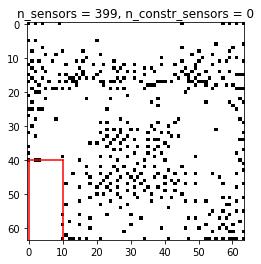

In [11]:
top_sensors = model1.get_selected_sensors()
print(top_sensors)
## TODO: this can be done using ravel and unravel more elegantly
yConstrained = np.floor(top_sensors[:n_const_sensors]/np.sqrt(n_features))
xConstrained = np.mod(top_sensors[:n_const_sensors],np.sqrt(n_features))

img = np.zeros(n_features)
img[top_sensors] = 16
img[top_sensors[n_const_sensors:]] = 16
plt.plot(xConstrained,yConstrained,'*r')
plt.plot([xmin,xmin],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymax,ymax],'r')
plt.plot([xmax,xmax],[ymin,ymax],'r')
plt.plot([xmin,xmax],[ymin,ymin],'r')
plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)
plt.title('n_sensors = {}, n_constr_sensors = {}'.format(n_sensors,n_const_sensors))
plt.show()
    

In [12]:
print(n_sensors)
print(idx_constrained.shape)

399
(230,)
